# 高斯混合分布 Gaussian Mixture Model
## 算法实现 implementation of algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### 数据集 Dataset

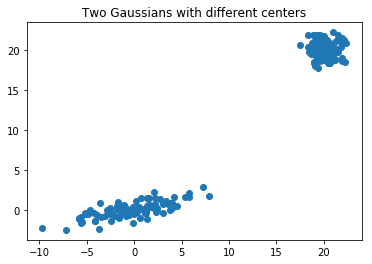

In [2]:
np.random.seed(0)
# generate spherical data centered on (20, 20)
shifted_gaussian = np.random.randn(100, 2) + np.array([20, 20])
# generate zero centered stretched Gaussian data
C = np.array([[0., -0.7], [3.5, .7]])
stretched_gaussian = np.dot(np.random.randn(100, 2), C)
# concatenate the two datasets into the final training set
X = np.vstack([shifted_gaussian, stretched_gaussian])
plt.scatter(X[:,0], X[:,1])
plt.title("Two Gaussians with different centers")
plt.show()

In [3]:
from scipy.stats import multivariate_normal
class GaussianMixture():
    def __init__(self,n_components):
        self.n_components = n_components
        self.mean=None
        self.cov=None
        self.alpha=None
    
    def fit(self, X_train, tol=0.001, n_iters=1000):
        # 初始化
        n_samples, n_features = X_train.shape
        alpha = np.ones(self.n_components) / self.n_components
        cov = np.array([np.eye(n_features)] * self.n_components)
        u = np.random.rand(self.n_components, n_features)
        iters = 0
        for _ in range(n_iters):
            gamma = self.calc_expectation(X_train, u, cov, alpha)
            u_, cov_, alpha_ = self.calc_maximization(X_train, gamma)
            # 迭代过小退出
            if np.sum(u_-u) + np.linalg.norm(cov_-cov) + np.sum(alpha_-alpha) < tol : 
                break
            else : 
                u = u_.copy(); cov = cov_.copy(); alpha = alpha_.copy()
                iters += 1
        self.mean = u_
        self.cov = cov_
        self.alpha = alpha_
        print(f"Training finished after {iters} iterations!")
        
    def calc_expectation(self, X_train, u, cov, alpha):
        n_samples, n_features = X_train.shape
        # gamma 响应度
        gamma = np.zeros((self.n_components, n_samples))
        for i in range(self.n_components):
            gamma[i] = multivariate_normal.pdf(X_train, mean=u[i], cov=cov[i]) * alpha[i]
        gamma = gamma / np.sum(gamma, axis=0)
        return gamma
    
    def calc_maximization(self, X_train, gamma):
        n_samples, n_features = X_train.shape
        u = np.zeros((self.n_components, n_features))
        cov = []
        nk = np.sum(gamma,axis=1)
        # 更新权重 alpha
        alpha = nk / n_samples
        for k in range(self.n_components):
            # 更新均值 u
            for f in range(n_features):
                u[k,f] = np.sum(gamma[k] * X_train[:,f]) / nk[k]
            # 更新方差 cov
            cov_sum = 0
            for i in range(n_samples):
                cov_sum += gamma[k,i] * np.dot(np.transpose([X_train[i] - u[k]]),[(X_train[i] - u[k])]) / nk[k]
            cov.append(cov_sum)
        return u, np.array(cov), alpha
    
    def predict(self, X):
        gamma = self.calc_expectation(X, self.mean, self.cov, self.alpha)
        return np.argmax(gamma,axis=0)
    
    def score_samples(self, X):
        return np.log(np.sum([multivariate_normal.pdf(X, mean=self.mean[i], cov=self.cov[i]) * self.alpha[i] 
                              for i in range(self.n_components)],axis=0) + 10**-300)

### 测试 Testing

In [4]:
clu = GaussianMixture(n_components=2)
clu.fit(X)

Training finished after 4 iterations!


In [5]:
print(clu.mean,'\n')
print(clu.cov,'\n')
print(clu.alpha)

[[-0.39532722  0.02108939]
 [19.99904232 20.14277867]] 

[[[10.41708062  2.27554936]
  [ 2.27554936  0.94857215]]

 [[ 1.04439794 -0.02492029]
  [-0.02492029  1.03188093]]] 

[0.5 0.5]


### 可视化概率密度 Visualize Density Estimation

In [6]:
def plot_density_estimation(clf, X_train): 
    # display predicted scores by the model as a contour plot
    from matplotlib.colors import LogNorm
    x = np.linspace(-20., 40.)
    y = np.linspace(-20., 40.)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = -clf.score_samples(XX)
    Z = Z.reshape(X.shape)

    CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                     levels=np.logspace(0, 3, 10))
    CB = plt.colorbar(CS, shrink=0.8, extend='both')
    plt.scatter(X_train[:, 0], X_train[:, 1], .8,c=clf.predict(X_train))
    plt.title('Negative log-likelihood predicted by a GMM')
    plt.axis('tight')
    plt.show()

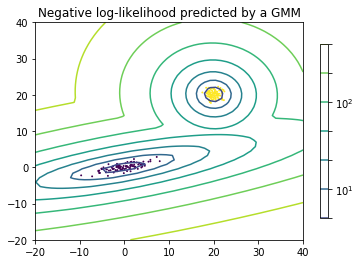

In [7]:
plot_density_estimation(clu, X)

## scikit-learn

In [8]:
from sklearn import mixture
clf = mixture.GaussianMixture(n_components=2)
clf.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [9]:
print(clf.means_,'\n')
print(clf.covariances_,'\n')
print(clf.weights_,)

[[19.99904232 20.14277867]
 [-0.39532722  0.02108939]] 

[[[ 1.04439894 -0.02492029]
  [-0.02492029  1.03188193]]

 [[10.41708162  2.27554936]
  [ 2.27554936  0.94857315]]] 

[0.5 0.5]


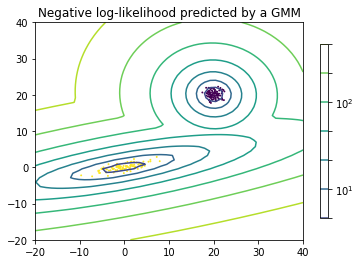

In [10]:
plot_density_estimation(clf, X)